# Test of Keras_tuner
https://keras.io/keras_tuner/

## Library Import

In [1]:
import keras_tuner
import tensorflow as tf
from tensorflow import keras
import sys
sys.path.insert(0, '../../')
from library.notebook_api.data_loader import  ModelDataLoader

2024-12-07 20:08:13.985497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Demo in Docs

In [2]:
def build_model(hp):
  model = K.Sequential()
  model.add(K.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(K.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model

In [3]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

Reloading Tuner from ./untitled_project/tuner0.json


## Demo using cnn+ lstm
Based on last scenario in CNN_LSTM_MFCC_Classification , define a function for test train data and function for model 

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

#data functions
def get_numerical_vector_smote_v005_data():
    # Initialize ModelDataLoader with the correct directory path
    model_data_loader = ModelDataLoader(version='005')
    # Reload filtered_df from the original dataset
    filtered_df = model_data_loader.df.copy()

    # Ensure the features column doesn't have any None values
    filtered_df = filtered_df[filtered_df['features'].notnull()]

    # Include only relevant genres (ensure 'classical' is included)
    selected_genres = ['rock', 'electronic', 'hiphop', 'classical', 'jazz', 'country']

    # Filter the DataFrame for the selected genres
    filtered_df = filtered_df[filtered_df['label'].isin(selected_genres)].copy()

    # Preprocess features to ensure consistent shape
    max_length = max(filtered_df['features'].apply(lambda x: len(x)))

    # Pad or truncate features
    def pad_or_truncate(array, max_length):
        if len(array) < max_length:
            # Pad with zeros
            return np.pad(array, (0, max_length - len(array)), mode='constant')
        else:
            # Truncate to max_length
            return array[:max_length]

    # Apply padding/truncating to all features
    filtered_df['features_padded'] = filtered_df['features'].apply(lambda x: pad_or_truncate(x, max_length))

    # Convert to 2D NumPy array
    X = np.array(filtered_df['features_padded'].tolist())

    print(f"Shape of X after padding/truncating: {X.shape}")

    # Extract and encode labels
    y = filtered_df['label'].values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    '''
    #original SMOTE
    # Apply SMOTE for balancing
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

    # Verify the balanced class distribution
    print("Class distribution after SMOTE:")
    unique, counts = np.unique(y_resampled, return_counts=True)
    for label, count in zip(label_encoder.inverse_transform(unique), counts):
        print(f"{label}: {count}")

    # Add a channel dimension for CNN input
    X_resampled = X_resampled[..., np.newaxis]

    print(f"Shape of X_resampled: {X_resampled.shape}")
    print(f"Shape of y_resampled: {y_resampled.shape}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
    '''
    #'''
    #update to put smote after train test split just on train data
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Add a channel dimension for CNN input
    X_train_resampled, X_test = X_train_resampled[..., np.newaxis],X_test[..., np.newaxis]

    return X_train_resampled, X_test, y_train_resampled, y_test, label_encoder
    #'''
    return X_train, X_test, y_train, y_test, label_encoder 


def get_feature_vecor_data(vector_type = 'mfcc',version_string = '005',vector_length = 1200, apply_normalization = False):
    model_data_loader = ModelDataLoader(version_string)
    model_data_loader_df = model_data_loader.df
    features = []
    vector_height = 0
    if vector_type == 'mfcc':
        print('Loading mfcc vectors')
        features = model_data_loader.get_mfcc()
        vector_height = 13
    else:
        print('Loading log mel vectors')
        features = model_data_loader.get_log_melspectrogram()
        vector_height = 128

    labels_series = model_data_loader.df['label']
    #array of feature shapes
    feature_shapes = [feature.shape[1] for feature in features]
    print("features shape distribution")
    print(pd.Series(feature_shapes).value_counts())
    print("total records: ", len(features))

    #filter based on features
    # currently filtered to just the most common shapes, as we'll need to normalize shapes prior to training 
    #MFCC_LENGTH_CUTOFF = 2582
    #MFCC_LENGTH_CUTOFF = 500
    MFCC_LENGTH_CUTOFF = vector_length


    #array of indexes matching a predicate 
    in_scope_feature_indexes = np.where(np.array(feature_shapes) >= MFCC_LENGTH_CUTOFF)[0]
    print("normalized length: ",len(in_scope_feature_indexes))

    #filter based on labels
    #pick subset of labels that are more intuitively representative of genre 
    #genres like pop which are ambiguous are removed 
    in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']
    #optain the indexes of label series wher the label is in the list 
    in_scope_label_indexes = np.array(
        (labels_series[
                        labels_series
                            .apply(lambda x: True if x in  in_scope_labels else False)
                    ]
                            .index
        )
    )
    gtzan_indexes = np.array(
        (model_data_loader_df[
                        model_data_loader_df['dataset']
                            .apply(lambda x: True if x == 'gtzan' else False)
                    ]
                            .index
        )
    )

    #combine filter for the in scope labels with the same for in scope features 
    in_scope_indexes = [index for index in in_scope_label_indexes if index in in_scope_feature_indexes]
    print("Row Count after label based filter: ", len(in_scope_label_indexes))
    print("Final Row count after label and feature filter: ", len(in_scope_indexes))

    #label encoding
    in_scope_label_series = labels_series.iloc[in_scope_indexes]
    unique_label_names = in_scope_label_series.unique()
    unique_label_count = len(in_scope_label_series.unique())
    label_to_int_map = {}
    for index, label in enumerate(unique_label_names):
        label_to_int_map[label] = index  


    int_to_label_map = {v: k for k, v in label_to_int_map.items()}

    #numerical_labels = labels_series.map(label_to_int_map)
    numerical_labels = in_scope_label_series.map(label_to_int_map)

    encoded_labels = tf.one_hot(indices = numerical_labels.values, depth = len(unique_label_names))
    print("Unique label count: ", unique_label_count)
    print("label data count " , len(encoded_labels))

    #truncate features to consistent length while reshaping 
    reshaped_features = []
    feature_array = []
    for feature in features[in_scope_indexes]:
        mfcc = [] 
        for vector in feature: 
            mfcc.append(vector[0:MFCC_LENGTH_CUTOFF])
            mfcc_reshaped = np.array(mfcc)
        feature_array.append(mfcc_reshaped)
        reshaped_features.append(mfcc_reshaped.reshape((MFCC_LENGTH_CUTOFF,vector_height,1)))
    
    #generate train and test with stratification for equal label distribution across train and test 
    TEST_SIZE = .2

    X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_features), encoded_labels.numpy(), test_size=TEST_SIZE, random_state=42, stratify =encoded_labels.numpy() )
    if apply_normalization:
        print('applying normaization')
        # Create a normalization layer
        norm_layer = keras.layers.Normalization()
        # Adapt the layer to your data
        norm_layer.adapt(X_train)

        X_train,X_test= norm_layer(X_train),norm_layer(X_test)
    return X_train, X_test, y_train, y_test 



In [3]:
#function for returning compiled model, passing hp for hyper paramerter tuning 
def get_cnn_lstm(hp):
    #usedict argument for manually set, otherwise use hp
    if isinstance(hp, dict):
        learning_rate = hp['learning_rate']
    else:
        learning_rate = hp.Choice("learning_rate", values=[0.001, 0.0001])

    # Define the fine-tuned CNN+LSTM model
    model = keras.models.Sequential([
        # CNN Layers
        keras.layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(pool_size=2),

        keras.layers.Conv1D(256, kernel_size=3, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(pool_size=2),

        keras.layers.Dropout(0.3),
        #'''
        #LSTM Layers
        keras.layers.LSTM(256, return_sequences=True, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),

        keras.layers.LSTM(128, return_sequences=False, activation='relu'),
        keras.layers.Dropout(0.4),

        # Fully Connected Layers
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        #'''
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),

        # Output Layer
        keras.layers.Dense(6, activation='softmax')  # Adjust for number of classes
    ])
    # Compile the model with a custom learning rate
 
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)  # Initial learning rate
    #update optimizer with clipping to handle exploding gradients in mfcc
    #optimizer = keras.optimizers.Adam(learning_rate=learning_rate,clipvalue=0.5)  # Initial learning rate

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def get_2d_cnn(hp):
    #usedict argument for manually set, otherwise use hp
    if isinstance(hp, dict):
        learning_rate = hp['learning_rate']
    else:
        learning_rate = hp.Choice("learning_rate", values=[0.001, 0.0001])
    
    model = keras.Sequential(layers=[
        #https://www.youtube.com/watch?v=dOG-HxpbMSw
        #convulution 1
        keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
        keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        keras.layers.BatchNormalization(),
        #convolution 2
        keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
        keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        keras.layers.BatchNormalization(),
        #convolution 3
        keras.layers.Conv2D(32, (2,2), activation=keras.activations.relu),
        keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'),
        keras.layers.BatchNormalization(),
        #flatten and feed into dense layer with dropiut
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        #predictions
        keras.layers.Dense(6, activation=keras.activations.softmax)
        
    ])
    cce = keras.losses.categorical_crossentropy

    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=cce, metrics=['accuracy'])
    return model 


In [80]:
#sketch of augmentation

#based on shape of initial row, and provided segment numbers and overlaps produce array of in and out locations
def get_augmented_segment_boundaries(train_row, num_segments=6, overlap_factor=.2 ):
    full_duration = train_row.shape[0]
    
    equivalized_exact_duration_whole = int(full_duration/num_segments)

    remnant_after_rounding = full_duration - (equivalized_exact_duration_whole *num_segments)

    base_duration_array = [equivalized_exact_duration_whole for index in list(range(0,num_segments)) ]

    padded_duration_array = [int(duration * (1 + overlap_factor)) for duration in base_duration_array]
    start_frame = 0
    end_frame = 0
    segment_boundaries = []
    for index, duration in enumerate(base_duration_array):
        segment_boundary = []
        if index != (num_segments -1):
            end_frame = start_frame + padded_duration_array[index]
        else:
            end_frame = full_duration - 1
            start_frame = end_frame - padded_duration_array[index]
        segment_boundary.append(start_frame)
        segment_boundary.append(end_frame)
        segment_boundaries.append(segment_boundary)
        start_frame += base_duration_array[index]

        #print(index, duration)
    return segment_boundaries


def get_augmented_x_y( X,y, num_segments=8, overlap_factor=.4):
    segment_boundaries = get_augmented_segment_boundaries(X[0],num_segments, overlap_factor)
    print("creating augmented data with segment boundaries", segment_boundaries)

    #for oversampling minority
    y_flattened = np.argmax(y,axis=1)
    _, counts = np.unique(y_flattened,return_counts=True)
    #instantiate probability of each label
    label_weights = counts / np.sum(counts)
    inv_label_weights = 1 - label_weights
    print(inv_label_weights)

    augmented_X=[]
    augmented_y = []
    for index, train_row in enumerate(X):
        row_sample_weight = inv_label_weights[y_flattened[index]]
        if row_sample_weight > .9:
            row_sample_weight = 1
        else:
            row_sample_weight = row_sample_weight * .1
        for segment_boundary in segment_boundaries:
            if np.random.binomial(1, row_sample_weight) ==1:
            #if row_sample_weight > .8:
                augmented_X.append(train_row[segment_boundary[0]:segment_boundary[1]])
                augmented_y.append(y[index])
    return np.array(augmented_X), np.array(augmented_y)


@misc{omalley2019kerastuner,
    title        = {KerasTuner},
    author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others},
    year         = 2019,
    howpublished = {\url{https://github.com/keras-team/keras-tuner}}
}

In [ ]:
#should adjust so that less additional samples taken from minority class
for index in list(range(0,3)):
    print('outer' , index)
    for index_a in list(range(0,3)):
        print('innder', index_a)
        if index_a ==1:
            break
        

outer 0
innder 0
innder 1
outer 1
innder 0
innder 1
outer 2
innder 0
innder 1


In [231]:
m=ModelDataLoader('006')

In [232]:
m.class_distribution

,label,proportion
0,rock,48.624595
1,electronic,33.692916
2,hiphop,5.267889
3,classical,5.007192
4,jazz,4.764473
5,country,2.642934


In [56]:
#X_train, X_test, y_train, y_test, label_encoder = get_numerical_vector_smote_v005_data()

#'''
X_train, X_test, y_train, y_test =get_feature_vecor_data(vector_type = 'mfcc',
                                                        version_string = '006',
                                                        vector_length = 1000, 
                                                        apply_normalization = True)
#'''
#re-format the labels to back to single dimensional array
#y_train, y_test = np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)

Loading mfcc vectors
features shape distribution
1099    19185
1         214
293         2
173         2
862         2
        ...  
841         1
759         1
768         1
824         1
432         1
Name: count, Length: 76, dtype: int64
total records:  19476
normalized length:  19191
Row Count after label based filter:  19476
Final Row count after label and feature filter:  19191
Unique label count:  6
label data count  19191
applying normaization


In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([15352, 1000, 13, 1]),
 TensorShape([3839, 1000, 13, 1]),
 (15352, 6),
 (3839, 6))

In [81]:
X_train_, y_train_ = get_augmented_x_y(X_train, y_train)
#X_test_, y_test_  = get_augmented_x_y(X_test, y_test)

creating augmented data with segment boundaries [[0, 175], [125, 300], [250, 425], [375, 550], [500, 675], [625, 800], [750, 925], [824, 999]]
[0.5620766  0.65743877 0.85194112 0.97146952 0.97238145 0.98469255]


In [82]:
X_train_.shape, y_train_.shape

((16269, 175, 13, 1), (16269, 6))

In [83]:
np.unique(np.argmax(y_train_,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([3049, 2864, 1580, 3504, 3392, 1880]))

In [84]:
np.unique(np.argmax(y_train,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([6723, 5259, 2273,  438,  424,  235]))

In [76]:
_, count =np.unique(np.argmax(y_train,axis=1),return_counts=True)

In [77]:
inv_prob = 1-(count/np.sum(count))
inv_prob

array([0.5620766 , 0.65743877, 0.85194112, 0.97146952, 0.97238145,
       0.98469255])

In [215]:
X_train_.shape, X_test_.shape, y_train_.shape, y_test_.shape

((15000, 207, 128, 1), (3756, 207, 128, 1), (15000, 6), (3756, 6))

In [216]:
X_train, X_test, y_train, y_test = X_train_, X_test_, y_train_, y_test_

In [14]:
selected_hp = {'learning_rate':  0.0001}
#selected_hp = {'learning_rate':  0.001}

type(selected_hp)
model = get_cnn_lstm(selected_hp)
#model = get_2d_cnn(selected_hp)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    
    #batch_size=32,
    #batch_size=64,
    batch_size = 128,
    #epochs=200,
    epochs=200,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        #lr_scheduler  # Learning rate scheduler
    ]
)
#first overnight unscaled 500 long mfcc data with  .5 ,clipping
#looked to be plateuing on accuracy at 43, at epoch 10

#second adjusted learning rate to .001 and reran, and loss exploded

#left off on third applied normalization moved learning rate back , 
# loss started out very high then went up and down, first batch hit 43

#to do , implement checkpoint in the keras_tuner implementation
#allow to run different lr scenarios overnight and save the models

Epoch 1/200
273/273 [==============================] - 15s 39ms/step - loss: 1.6460 - accuracy: 0.2928 - val_loss: 1.6412 - val_accuracy: 0.2541
Epoch 2/200
273/273 [==============================] - 10s 36ms/step - loss: 1.5053 - accuracy: 0.3720 - val_loss: 1.5412 - val_accuracy: 0.3277
Epoch 3/200
273/273 [==============================] - 9s 34ms/step - loss: 1.4539 - accuracy: 0.4043 - val_loss: 1.5245 - val_accuracy: 0.3389
Epoch 4/200
273/273 [==============================] - 10s 36ms/step - loss: 1.4228 - accuracy: 0.4311 - val_loss: 1.5246 - val_accuracy: 0.3431
Epoch 5/200
273/273 [==============================] - 10s 36ms/step - loss: 1.3983 - accuracy: 0.4471 - val_loss: 1.4686 - val_accuracy: 0.4504
Epoch 6/200
273/273 [==============================] - 10s 38ms/step - loss: 1.3719 - accuracy: 0.4668 - val_loss: 1.4553 - val_accuracy: 0.4305
Epoch 7/200
273/273 [==============================] - 11s 40ms/step - loss: 1.3546 - accuracy: 0.4766 - val_loss: 1.3442 - val_acc

In [36]:
#notes, adjustmetn when increasing dimensionality of features
# learning rate unstable at 32 batch size, and 

#also note as a variable, supplying separate test data for validation 
#compare this .fit call with cnn_exploration

In [ ]:
# Save the model
#batch 64, epochs 100, could have gone longer
#model.save('v5_mfcc_13_1000_cnn_lstm.keras')

#--below are all not mfc, but numerical vecotrs
#reached 70 at 64 epochs out of 200, early stopping kicked in at 157
#model.save('v5_mfcc_13_44100_1000_cnn_lstm_128_batch_200_epoch.keras')

## highest so far
#this one, bowies architecture and v5 feature vector able to get 77%
#model.save('v5_mfcc_13_44100_1000_cnn_lstm_128_batch_200_epoch.keras')


#all .0001 learning rate 
#switch to initial cnn architecture , 65 by second epic
#model.save('v5_mfcc_unscaled_13_44100_500_cnn_2d_128_batch_200_epoch.keras')

#switch to initial cnn architecture , 65 by second epic, 74% total 
#model.save('v5_mfcc_scaled_13_44100_500_cnn_2d_128_batch_200_epoch.keras')

#early stopping stoped this at epic 104,  loss was still going down but val accuracy plateued at 75%
#could be worth trying again with adjusting the early stopping 
#model.save('v5_mfcc_scaled_13_44100_1200_cnn_2d_128_batch_200_epoch_lr_0001.keras')

#same as above but leraing rate adjust to 001, early stopping patience to 6 , 74.6
# early stopping kiled at 20, possibly could have gone longer
#model.save('v5_mfcc_scaled_13_44100_1200_cnn_2d_128_batch_200_epoch_lr_001.keras')

#same as above but leraing rate adjust to 001, early stopping patience to 6 , 74.6
# early stopping kiled at 20, possibly could have gone longer
#model.save('v6_logmel_scaled_128_22500_500_cnn_2d_128_batch_200_epoch_lr_0001.keras')

#this scenario was over-fitting,  training accuracy was getting into high 80s, but validation plateued in 50s
#model.save('v6_logmel_scaled_128_22500_augmented_6_25_207_cnn_2d_128_batch_200_epoch_lr_0001.keras')

#same as above, learning rate adjusted, same overfitting plateued around 5th epic
#model.save('v6_logmel_scaled_128_22500_augmented_6_25_207_cnn_2d_128_batch_200_epoch_lr_001.keras')

#First with v6 b , plateued at or near 76% accuracy , slow to train
#model.save('v6b_logmel_scaled_128_22500_500_cnn_2d_128_batch_200_epoch_lr_0001.keras')

#same as above but mfcc, faster to train 74.9
model.save('v6b_mfcc_scaled_128_22500_500_cnn_2d_128_batch_200_epoch_lr_0001.keras')

In [121]:
#model = keras.saving.load_model("v5_mfcc_scaled_13_44100_500_cnn_2d_128_batch_200_epoch.keras")
#model = keras.saving.load_model("v5_mfcc_unscaled_13_44100_500_cnn_2d_128_batch_200_epoch.keras")
model = keras.saving.load_model("v5_mfcc_scaled_13_44100_1200_cnn_2d_128_batch_200_epoch_lr_0001.keras")

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

104/104 - 1s - loss: 1.1187 - accuracy: 0.5755 - 554ms/epoch - 5ms/step

Test Accuracy: 57.55%
Test Loss: 1.1187


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns


In [17]:
#validation 
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
#remap the ints to string names 
#label_names = [int_to_label_map[int_label] for int_label in np.unique(numerical_labels)]
label_names = np.unique(y_true)

confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

104/104 [==============================] - 2s 12ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [242]:
  # Classification report
  print("\nClassification Report:")
  print(classification_report(y_true, y_predicted))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1073
           1       0.72      0.79      0.75       733
           2       0.63      0.44      0.52       117
           3       0.77      0.69      0.72       109
           4       0.49      0.20      0.28       106
           5       0.20      0.02      0.03        59

    accuracy                           0.75      2197
   macro avg       0.60      0.50      0.52      2197
weighted avg       0.73      0.75      0.73      2197



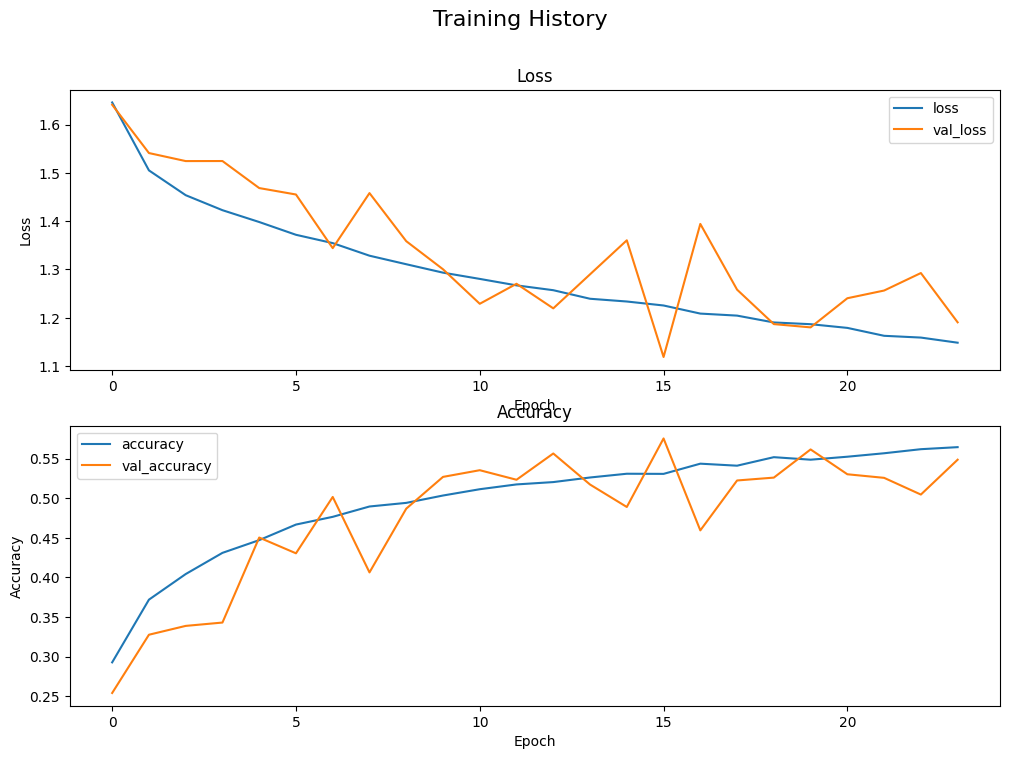

In [18]:
# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

In [33]:
# Train 
#another reference: https://keras.io/keras_tuner/guides/distributed_tuning/
# and here as well: https://keras.io/keras_tuner/getting_started/

tuner = keras_tuner.RandomSearch(
    get_cnn_lstm,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuner",
    project_name= "initial_test_01",
    
    )

tuner.search(
    X_train,
    y_train,
    epochs = 5,
    #steps_per_epoch=600,
    validation_data=(X_test, y_test),
    #validation_steps=100,
    callbacks=[K.callbacks.EarlyStopping("val_accuracy")],
)

best_model = tuner.get_best_models()[0]



Trial 2 Complete [00h 01m 47s]
val_accuracy: 0.4779664874076843

Best val_accuracy So Far: 0.49839338660240173
Total elapsed time: 00h 03m 52s


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
tuner.results_summary()

In [ ]:
#issue with tuner is that by default it is not keeping history, 
#as workaround can train again to get history of new model 
#history = tuner.get_best_models()[0].history